# Gender Classification and Eyes Location Detection: A Two Task Problem

In this example, we are going to implement a multi-task problem. We try to identify the gender of the people, as well as locating their eyes in the image. Hence, we have two different tasks: classification (to identify the gender) and regression (to find the location of the eyes). We are going to use a single network (a CNN) to perform both tasks, however, we will need to apply different loss functions, each proper to a specific task. For this example we will need to install a few libraries (such as OpenCV, wget). If you don't have them, they can be installed as below:

In [1]:
%pip install poutyne          # to install the Poutyne library
%pip install wget             # to install the wget library in order to download data
#%pip install opencv-python    # to install the cv2 (opencv) library

     |████████████████████████████████| 136 kB 8.1 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9673 sha256=e09a63f375ac460f314b5b138c9f3e3958af99fca69aa74ec4f7e9876e5df83f
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


Let’s import all the needed packages.

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import math
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wget
import zipfile
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as tfms
from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger, Experiment, StepLR
from torch.utils.data import DataLoader, Subset, Dataset  
from torchvision.utils import make_grid


## Training Constants

In [3]:
num_epochs = 15
learning_rate = 0.001
batch_size = 32
image_size = 224
w, h = 218, 178   # the width and the hight of original images before resizing
valid_split_percent = 0.1  
momentum = 0.5
set_seeds(42)
gender_index = 20 # in the CelebA dataset gender information is the 21th item in the attributes vector.
W = 1.3 # the weight of regression loss 
imagenet_mean = [0.485, 0.456, 0.406]  # mean of the ImageNet dataset for normalizing 
imagenet_std = [0.229, 0.224, 0.225]  # std of the ImageNet dataset for normalizing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('The running processor is...', device) 

The running processor is... cuda


## CelebA Dataset

We are going to use the CelebA dataset for this experiment. The CelebA 
dataset  is a large-scale face attributes dataset which can be employed as the training and test sets for the following computer vision tasks: face attribute recognition, face detection, landmark (or facial part) localization, and face editing & synthesis.

## Fetching data 


The section below consists of a few lines of codes that help us download the CelebA dataset from a public web source and unzip it. Downloading the CelebA dataset can be also done directly using `torch.datasets.CelebA(data_root, download=True)`. However, due to the high traffic on the dataset's Google Drive (the main source of the dataset), it usually fails to function. Hence we decided to download it from another public source but use it with `torch.datasets.CelebA()`.

In [4]:
data_root = 'datasets'  

base_url = "https://graal.ift.ulaval.ca/public/celeba/"

file_list = [
    "img_align_celeba.zip",
    "list_attr_celeba.txt", 
    "identity_CelebA.txt",
    "list_bbox_celeba.txt",
    "list_landmarks_align_celeba.txt",
    "list_eval_partition.txt"
]

# Path to folder with the dataset
dataset_folder = f'{data_root}/celeba'
os.makedirs(dataset_folder, exist_ok=True)

for file in file_list:
    url = f"{base_url}/{file}"
    if not os.path.exists(f"{dataset_folder}/{file}"):
      wget.download(url, f"{dataset_folder}/{file}")

with zipfile.ZipFile(f"{dataset_folder}/img_align_celeba.zip", 'r') as ziphandler:
    ziphandler.extractall(dataset_folder)

Now, as the dataset id downloaded, we can define our datasets and dataloaders in its original way.

In [5]:
transforms = tfms.Compose([
  tfms.Resize((image_size, image_size)),
  tfms.ToTensor(),
  tfms.Normalize(imagenet_mean, imagenet_std)
])
train_dataset = datasets.CelebA(
  data_root,
  split='train',
  target_type=['attr', 'landmarks'],
  transform=transforms)
valid_dataset = datasets.CelebA(
  data_root, 
  split='valid', 
  target_type=['attr', 'landmarks'], 
  transform=transforms)
test_dataset = datasets.CelebA(
  data_root, 
  split='test', 
  target_type=['attr', 'landmarks'], 
  transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Here we can see how each dataset sample looks like:

In [6]:
print (train_dataset[0])

(tensor([[[ 2.2147,  2.2147,  2.2147,  ...,  2.1804,  2.2318,  2.2318],
         [ 2.2147,  2.2147,  2.2147,  ...,  2.1975,  2.2318,  2.2318],
         [ 2.2147,  2.2147,  2.2147,  ...,  2.2147,  2.2489,  2.2489],
         ...,
         [ 0.2624,  0.0056,  0.1426,  ..., -0.0287, -0.0287, -0.0287],
         [ 0.1426,  0.2453,  0.5364,  ..., -0.0972, -0.0972, -0.0972],
         [ 0.7591,  1.1872,  1.7180,  ..., -0.0801, -0.0629, -0.0629]],

        [[ 2.0084,  2.0084,  2.0084,  ...,  2.0259,  2.1310,  2.1310],
         [ 2.0084,  2.0084,  2.0084,  ...,  2.0434,  2.1310,  2.1310],
         [ 2.0084,  2.0084,  2.0084,  ...,  2.0784,  2.1485,  2.1485],
         ...,
         [-0.7577, -1.0378, -0.9153,  ..., -1.0553, -1.0553, -1.0553],
         [-0.9153, -0.8102, -0.5126,  ..., -1.1604, -1.1429, -1.1429],
         [-0.2850,  0.1527,  0.6954,  ..., -1.1604, -1.1604, -1.1604]],

        [[ 1.5768,  1.5768,  1.5768,  ...,  2.0823,  2.0648,  2.0648],
         [ 1.5768,  1.5768,  1.5768,  ...,  

Regarding the complexity of the problem and the number of training/valid samples, we have a huge number of training/validation images. Since there are not a considerable varation between images (e.g., the eye coordinates in images do not vary considerably), using all images in the dataset is not necessary and will only increase the training time. Hence, we can seperate and use a portion of data as below:

In [7]:
train_subset = Subset(train_dataset, np.arange(1,5000))
valid_subset = Subset(valid_dataset, np.arange(1,500))
train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False)

Here, we can see an example from the training dataset. It shows an image of a person, printing the gender and also showing the location of the eyes. It is worth mentioning that as we resize the image, the coordinates of the eyes should also be changed with same ratio.

Gender is:  male


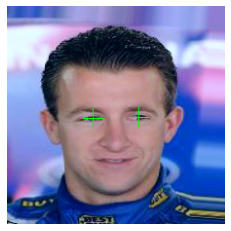

In [8]:
sample_number = 22
image = train_dataset[sample_number][0]
image = image.permute(1,2,0).detach().numpy()
image_rgb = cv2.cvtColor(np.float32(image), cv2.COLOR_BGR2RGB)
image_rgb = image_rgb * imagenet_std + imagenet_mean
gender = 'male' if int(train_dataset[sample_number][1][0][gender_index])==1 else 'female'
print('Gender is: ', gender)
w, h = 218, 178
(x_L, y_L) = train_dataset[sample_number][1][1][0:2]  # The coordinates vector of the datasets starts with X_L, y_L, X_R, y_R
(x_R, y_R) = train_dataset[sample_number][1][1][2:4]
w_scale = image_size/w
h_scale = image_size/h
x_L, x_R = (x_L*h_scale), (x_R*h_scale)  #rescaling for the size of (224,224) and finaly to the range of [0,1]
y_L, y_R = (y_L*w_scale), (y_R*w_scale)
x_L, x_R = int(x_L), int(x_R)
y_L, y_R = int(y_L), int(y_R)
image_rgb	= cv2.drawMarker(image_rgb, (x_L,y_L), (0,255,0))
image_rgb	= cv2.drawMarker(image_rgb, (x_R,y_R), (0,255,0))
image_rgb = cv2.cvtColor(np.float32(image_rgb), cv2.COLOR_BGR2RGB)
image_rgb = np.clip(image_rgb ,0 , 1)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

## Network

Below, we define a new class, named `ClassifierLocalizer`, which accepts a pre-trained CNN and changes its last fully connected layer to be proper for the two task problem. The new fully connected layer contains 6 neurons, 2 for the classification task (male or female) and 4 for the localization task (x and y for the left and right eyes). Moreover, to put the location results on the same scale as the class scores, we apply the sigmoid function to the neurons assigned for the localization task.

In [9]:
class ClassifierLocalizer(nn.Module):
    def __init__(self, model_name, num_classes=2):

      super(ClassifierLocalizer, self).__init__()
      self.num_classes = num_classes
      
      # create cnn model
      model = getattr(models, model_name)(pretrained=True)
      
      # remove fc layers and add a new fc layer
      num_features = model.fc.in_features
      model.fc = nn.Linear(num_features, 6) # classifier + localizer
      self.model = model
    
    def forward(self,X ):
        X = torch.tensor(X, requires_grad=True)
        x = self.model(X)                    # extract features from CNN
        scores = x[:, :self.num_classes]     # class scores
        coords = x[:, self.num_classes:]     # coordinates
        return scores, torch.sigmoid(coords)   # sigmoid output is in the range of [0, 1]

Regarding the complexity of the problem, the number of the samples in the training dataset, and the similarity of the training dataset to the ImageNet dataset, we may decide to freeze some of the layers. In our current example, based on the mentioned factors, we freeze all layers but the last fully connected layer.

In [10]:
network = ClassifierLocalizer(model_name='resnet18')

def freeze_weights(network):
    for name, param in network.named_parameters():
        if not name.startswith('fc.'):
            param.requires_grad = False

freeze_weights(network)
print(network)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth



ClassifierLocalizer(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

## Loss function

As we discussed before, we have two different tasks in this example. These tasks need different loss functions; Cross-Entropy loss for the classification and Mean Square Error loss for the regression. Below, we define a new loss function class that sums both losses to considers them simultaneously. However, as the regression is relatively a harder task, we apply a higher weight to MSEloss.

In [11]:
class ClassificationRegressionLoss(nn.Module):
    def __init__(self, W):
        super(ClassificationRegressionLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss() # size_average=False
        self.mse_loss = nn.MSELoss()
        self.W = W
        
    def forward(self, y_pred, y_true):
        loss_cls = self.ce_loss(y_pred[0], y_true[0][:,20]) # Cross Entropy Error (for classification)
        loss_reg1 = self.mse_loss(y_pred[1][:,0], y_true[1][:,0]/h) # Mean Squared Error for X_L
        loss_reg2 = self.mse_loss(y_pred[1][:,1], y_true[1][:,1]/w) # Mean Squared Error for Y_L
        loss_reg3 = self.mse_loss(y_pred[1][:,2], y_true[1][:,2]/h) # Mean Squared Error for X_R
        loss_reg4 = self.mse_loss(y_pred[1][:,3], y_true[1][:,3]/w) # Mean Squared Error for Y_R
        total_loss = loss_cls + self.W * (loss_reg1 + loss_reg2 + loss_reg3 + loss_reg4)
        return total_loss

## Training

In [12]:
optimizer = optim.SGD(network.parameters(), lr=0.005, weight_decay=0)
loss_function = ClassificationRegressionLoss(W)
exp = Experiment('./two_task_example', network, optimizer=optimizer, loss_function=loss_function, device="all")
exp.train(train_dataloader, valid_dataloader, epochs=num_epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch:  1/15 Train steps: 157 Val steps: 16 31.11s loss: 0.291738 val_loss: 0.152285
Epoch 1: val_loss improved from inf to 0.15228, saving file to ./two_task_example/checkpoint_epoch_1.ckpt
Epoch:  2/15 Train steps: 157 Val steps: 16 31.09s loss: 0.145904 val_loss: 0.102151
Epoch 2: val_loss improved from 0.15228 to 0.10215, saving file to ./two_task_example/checkpoint_epoch_2.ckpt
Epoch:  3/15 Train steps: 157 Val steps: 16 30.93s loss: 0.094248 val_loss: 0.041628
Epoch 3: val_loss improved from 0.10215 to 0.04163, saving file to ./two_task_example/checkpoint_epoch_3.ckpt
Epoch:  4/15 Train steps: 157 Val steps: 16 31.59s loss: 0.070053 val_loss: 0.030749
Epoch 4: val_loss improved from 0.04163 to 0.03075, saving file to ./two_task_example/checkpoint_epoch_4.ckpt
Epoch:  5/15 Train steps: 157 Val steps: 16 31.28s loss: 0.051397 val_loss: 0.031241
Epoch:  6/15 Train steps: 157 Val steps: 16 31.32s loss: 0.036531 val_loss: 0.015464
Epoch 6: val_loss improved from 0.03075 to 0.01546, sa

[{'epoch': 1,
  'loss': 0.29173806704361693,
  'time': 31.110406273000024,
  'val_loss': 0.15228473757933042},
 {'epoch': 2,
  'loss': 0.1459038618279114,
  'time': 31.091386992000025,
  'val_loss': 0.10215117277685769},
 {'epoch': 3,
  'loss': 0.09424761456503919,
  'time': 30.93009675099995,
  'val_loss': 0.041627575652692504},
 {'epoch': 4,
  'loss': 0.07005319869561949,
  'time': 31.592089663000024,
  'val_loss': 0.030748917144501137},
 {'epoch': 5,
  'loss': 0.051396793420373454,
  'time': 31.27918084700002,
  'val_loss': 0.031241327785478088},
 {'epoch': 6,
  'loss': 0.036531380994555045,
  'time': 31.319837641999925,
  'val_loss': 0.01546443341475331},
 {'epoch': 7,
  'loss': 0.02954945577653939,
  'time': 31.501869420999924,
  'val_loss': 0.01266445307049878},
 {'epoch': 8,
  'loss': 0.022803625893566902,
  'time': 31.176359739000077,
  'val_loss': 0.010610389125669648},
 {'epoch': 9,
  'loss': 0.018846753470496812,
  'time': 31.283821396000008,
  'val_loss': 0.0088299670488105

## Evaluation

As you have also noticed from the training logs, in this try we achieved the best performance (considering the validation loss) at the 15th epoch. The weights of the network for the corresponding epoch have been automatically saved by the `Experiment` function and we use these parameters to evaluate our algorithm visually. For this purpose, we utulize the load_checkpoint method and set its argument to `best` to load the best weights of the model automatically. Finally,  we take advantage of the `evaluate` function of Poutyne, and apply it to the validation dataset. It provides us the predictions as well as the ground-truth for comparison, in case of need.

In [13]:
exp.load_checkpoint('best')
model = exp.model
loss, predictions, Ground_Truth = model.evaluate_generator(valid_dataloader, return_pred=True, return_ground_truth=True)

Step:  2/16  12.50% |██▌                 |ETA: 1.83s test_loss: 0.004859

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


Test steps: 16 1.99s test_loss: 0.005209                                


In [14]:
logs = pd.read_csv('./two_task_example/log.tsv', sep='\t')
print(logs)

    epoch       time     lr      loss  val_loss
0       1  31.110406  0.005  0.291738  0.152285
1       2  31.091387  0.005  0.145904  0.102151
2       3  30.930097  0.005  0.094248  0.041628
3       4  31.592090  0.005  0.070053  0.030749
4       5  31.279181  0.005  0.051397  0.031241
5       6  31.319838  0.005  0.036531  0.015464
6       7  31.501869  0.005  0.029549  0.012664
7       8  31.176360  0.005  0.022804  0.010610
8       9  31.283821  0.005  0.018847  0.008830
9      10  31.184919  0.005  0.020624  0.007742
10     11  31.148742  0.005  0.012608  0.006776
11     12  31.307918  0.005  0.013650  0.006498
12     13  31.601807  0.005  0.011058  0.005642
13     14  31.707321  0.005  0.012819  0.005209
14     15  31.357428  0.005  0.009552  0.005823


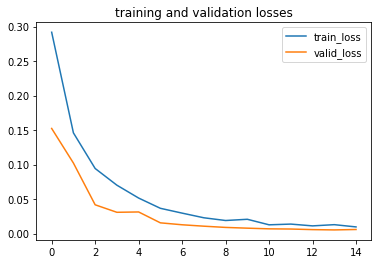

In [15]:
train_loss = logs.loss
valid_loss = logs.val_loss
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['train_loss','valid_loss'])
plt.title('training and validation losses')
plt.show()

We can also evaluate the performance of the trained network (a network with the best weights) on any dataset, as below:

In [16]:
exp.test(test_dataloader)

Found best checkpoint at epoch: 14
lr: 0.005, loss: 0.0128186, val_loss: 0.00520867
Loading checkpoint ./two_task_example/checkpoint_epoch_14.ckpt
Running test
Step:   2/624   0.32% |                    |ETA: 84.60s test_loss: 4.127592

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


Test steps: 624 83.97s test_loss: 4.604807                                


{'test_loss': 4.604806839637462, 'time': 83.97297285699995}

Now let's evaluate the performance of the network visually.

Gender is:  female


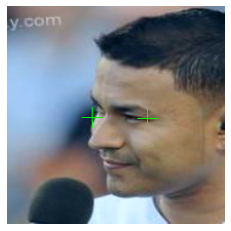

In [17]:
sample_number = 35
image = valid_dataset[sample_number][0]
image = image.permute(1,2,0).detach().numpy()
image_rgb = cv2.cvtColor(np.float32(image), cv2.COLOR_BGR2RGB)
image_rgb = image_rgb * imagenet_std + imagenet_mean
gender = 'male' if np.argmax(predictions[0][sample_number])==0 else 'female'
print('Gender is: ', gender)
(x_L, y_L) = predictions[1][sample_number][0:2]*image_size
(x_R, y_R) = predictions[1][sample_number][2:4]*image_size
x_L, x_R = int(x_L), int(x_R)
y_L, y_R = int(y_L), int(y_R)
image_rgb	= cv2.drawMarker(image_rgb, (x_L,y_L), (0,255,0))
image_rgb	= cv2.drawMarker(image_rgb, (x_R,y_R), (0,255,0))
image_rgb = cv2.cvtColor(np.float32(image_rgb), cv2.COLOR_BGR2RGB)
image_rgb = np.clip(image_rgb , 0, 1)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()